# Supervised graph classification example

This notebook demonstrates how to train a graph classification model in a supervised setting using graph convolutional layers followed by a mean pooling layer as well as any number of fully connected layers.

The graph convolutional classification model architecture is based on the one proposed in [1] (see Figure 5 in [1]) using the graph convolutional layers from [2]. This demo differs from [1] in that the dataset, MUTAG, is a collection of static graphs representing chemical compounds. Furthermore, none of the graph convolutional layers in our model utilise an attention head.

Evaluation data for graph kernel-based approaches are taken from [3].

**References**

[1] Fake News Detection on Social Media using Geometric Deep Learning, F. Monti, F. Frasca, D. Eynard, D. Mannion, and M. M. Bronstein, ICLR 2019. ([link](https://arxiv.org/abs/1902.06673))

[2] Semi-supervised Classification with Graph Convolutional Networks, T. N. Kipf and M. Welling, ICLR 2017. ([link](https://arxiv.org/abs/1609.02907))

[3] An End-to-End Deep Learning Architecture for Graph Classification, M. Zhang, Z. Cui, M. Neumann, Y. Chen, AAAI-18. ([link](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146))

In [1]:
import random
import pandas as pd
import numpy as np


import stellargraph as sg
from stellargraph.mapper import GraphGenerator
from stellargraph.layer import GraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets
from stellargraph.utils import plot_history

from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

## Import the data

In [2]:
dataset = datasets.MUTAG()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

Split the data into train and test sets

In [3]:
graph_labels_one_hot = pd.get_dummies(graph_labels)

### Prepare graph generator

To feed data to the Keras model that we will create later, we need a generator. For supervised graph classification, we need an instance of `GraphGenerator`.

In [4]:
generator = GraphGenerator(graphs=graphs)

### Create the Keras graph classification model

We are now ready to create a Keras graph classification model using the `GraphClassification` class together with standard Keras models, e.g., Dense. 

The below image shows the architecture we are going to use. The input is the graph (adjacency matrix and node features). The first two layers are Graph Convolutional as in [2] with each layer having 16 units and `relu` activations. The next layer is a mean pooling layer where the learned node representation are summarized to create a graph representation. The graph representation is input to two fully connected layers with 8 and 2 units repsectively. The last layer uses a `softmax` activation producing probabilities for the 2 graph labels.

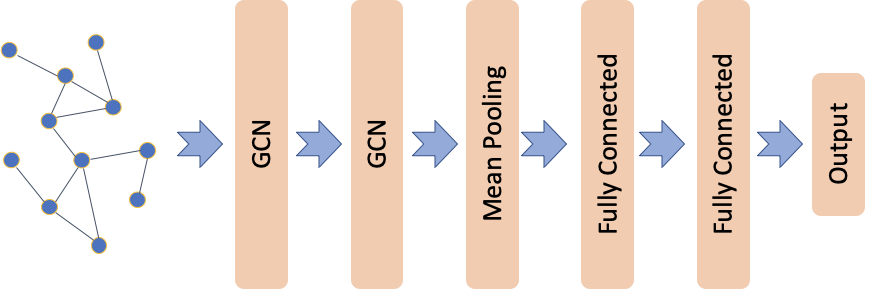

In [5]:
def create_graph_classification_model(generator):
    gc_model = GraphClassification(
        layer_sizes=[16, 16],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.build()
    predictions = Dense(units=8, activation="relu")(x_out)
    predictions = Dense(units=2, activation="softmax")(predictions)

    return x_inp, predictions

### Train the model

We can now train the model using the model's `fit` method.

In [6]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, restore_best_weights=True
)

In [7]:
def train_fold(model, train_gen, test_gen, es):
    history = model.fit(
        train_gen,
        epochs=100,
        validation_data=test_gen,
        verbose=0,
        shuffle=True,
        callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen)
    for name, val in zip(model.metrics_names, test_metrics):
        if name == "acc":
            test_acc = val
    return history, test_acc

In [8]:
best_model = None
best_model_history = None
best_model_test_acc = 0.0
test_accs = []

# For each fold, we are going to train the model num_restarts times. Each time, the model weights will be
# initialized to different values but the training and test data given to the model will be the same.
num_restarts = 3

es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, restore_best_weights=True
)

for train_index, test_index in model_selection.StratifiedKFold(
    n_splits=10, shuffle=True
).split(np.arange(len(graphs)), graph_labels):
    train_gen = generator.flow(
        train_index, targets=graph_labels_one_hot.iloc[train_index].values, batch_size=30
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels_one_hot.iloc[test_index].values, batch_size=1
    )
    best_test_acc_for_fold = 0
    for _ in range(num_restarts):
        x_inp, predictions = create_graph_classification_model(generator)
        model = Model(inputs=x_inp, outputs=predictions)
        model.compile(
            optimizer=Adam(0.001), loss=categorical_crossentropy, metrics=["acc"]
        )
        history, test_acc = train_fold(model, train_gen, test_gen, es)
        if test_acc > best_test_acc_for_fold:
            best_test_acc_for_fold = test_acc
        if (not best_model) or (test_acc > best_model_test_acc):
            # the best overall model
            best_model = tf.keras.models.clone_model(model)
            best_model_history = history
            best_model_test_acc = test_acc
    test_accs.append(best_test_acc_for_fold)

In [9]:
print(f"Best model test accuracy: {best_model_test_acc}")

Best model test accuracy: 0.9444444179534912


In [10]:
print(
    f"Accuracy over all folds mean: {np.round(np.mean(test_accs)*100, 1)} and std: {np.round(np.std(test_accs)*100,1)}"
)

Accuracy over all folds mean: 75.6 and std: 7.9


We are just going to plot the training history (losses and accuracies for the train and test data) for the best performing model.

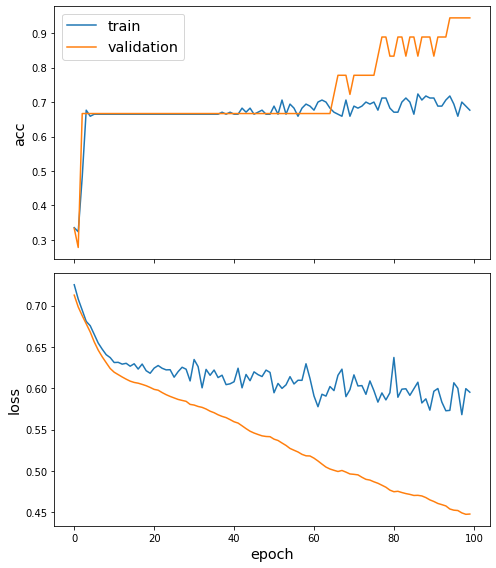

In [11]:
sg.utils.plot_history(best_model_history)

Average performance is $75.6\pm7.9$.

Generally, performance is a bit lower than SOTA in recent literature. However, we have not tuned the model for the best performance possible so some improvement over the current baseline could be possible.

When comparing to graph kernel-based approaches, our straightforward GCN with mean pooling graph classification model is competitive with the WL kernel being the exception.

For comparison, some performance numbers from [3] for graph kernel-based approaches are, 
- Graphlet Kernel (GK): $81.39\pm1.74$
- Random Walk Kernel (RW): $79.17\pm2.07$
- Propagation Kernel (PK): $76.00\pm2.69$
- Weisfeiler-Lehman Subtree Kernel (WL): $84.11\pm1.91$